# TP4: Travail Final 
## VANBELLE Julien

## Imports

In [ ]:
import os
import yake
import collections
import string
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import nltk
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from nltk import FreqDist
from nltk.corpus import webtext
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('webtext')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from IPython.display import Image
from collections import defaultdict
from pprint import pprint
import sys
import spacy
from spacy.lang.fr.examples import sentences
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
from tabulate import tabulate
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
from datetime import datetime
import dateutil.parser as dparser
from dateutil.parser._parser import _timelex
import re


txt_path = '/Users/julienvanbelle/Documents/GitHub/tac/data/txt'
data_path = '/Users/julienvanbelle/Documents/GitHub/tac/data'


## Data cleaning

In [ ]:
files = os.listdir(txt_path)
data_bxl = [f for f in files if f.startswith('Bxl_')]
len(data_bxl)


In [ ]:
data_list = []
for txt in data_bxl:
    with open(os.path.join(txt_path, txt), 'r', encoding = "ISO-8859-1") as f:
        data_list.append(f.read())

len(data_list)


In [ ]:
# Ecrire tout le contenu dans un fichier temporaire pour le nettoyer des stopwords propore au corpus
if not os.path.exists(data_path):
    os.mkdir(data_path)
with open(os.path.join(data_path, f'_temp.txt'), 'w') as f:
    f.write(' '.join(data_list))
    print("temp file saved in",data_path)

In [ ]:
wt_words = webtext.words('{}/_temp.txt'.format(data_path))
data_analysis = nltk.FreqDist(wt_words)
 
filter_words = dict([(m, n) for m, n in data_analysis.items() if len(m) > 3])
data_analysis = nltk.FreqDist(filter_words)
data_analysis.plot(30, cumulative=False)

In [ ]:
addsw = []
for z in sorted(filter_words):
  if filter_words[z] > 25000:
   addsw.append(z)

print(addsw)

In [ ]:
# Stopwords
swLower = ' '.join(str(e).lower() for e in addsw)
sw = stopwords.words("french")
sw += addsw
sw += swLower
sw += "conseil communal", "conseil général", "conseil supérieur", "administration communale", "conseil provincial", "l'administration communale", "conseil", "echevin" , "messieurs", "bruxelles", "bourgmestre", "collège", "être"
sw = set(sw)
print(sw)

In [ ]:
def clean_text(u, folder=None):
    if folder is None:
        input_path = f".txt"
        output_path = f"_clean.txt"
    else:
        ##for u in data_bxl:
            input_path = f"{folder}" + "/" + u
            output_path = data_path + "/txt_cleaned/" + "Clean_" + u ##opti ici avec {folder}
            print("Cleaning ==> " +u)
    
            output = open(output_path, "w", encoding="ISO-8859-1")
            with open(input_path, encoding="ISO-8859-1") as g:
                text = g.read()
                words = nltk.wordpunct_tokenize(text)
                kept = [w.lower() for w in words if len(w) > 2 and w.isalpha() and w.lower() not in sw]
                kept_string = " ".join(kept)
                output.write(kept_string)
            return f'Output has been written in {data_path + "/txt_cleaned"}!'

In [ ]:

if not os.path.exists(data_path +"/txt_cleaned"):
    os.mkdir(data_path + "/txt_cleaned")
for x in data_bxl:
    clean_text(x, folder=txt_path)

In [ ]:
# Vérifier le résultat
with open(os.path.join(data_path + "/txt_cleaned/" + "Clean_" + data_bxl[0]), 'r', encoding="ISO-8859-1") as f:
    after = f.read()

after[:5000]

In [ ]:
clean_path = data_path + "/txt_cleaned/"

clean_files = os.listdir(clean_path)
clean_list = []
for j in clean_files:
    with open(os.path.join(clean_path, j), 'r', encoding = "ISO-8859-1") as f:
        clean_list.append(f.read())

len(clean_list)

## Répartition du corpus en clusters

### TF/IDF

In [ ]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

In [ ]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

In [ ]:
%time tfidf_vectors = vectorizer.fit_transform(clean_list)

In [ ]:
# Détail de la matrice
tfidf_vectors

In [ ]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

### K-means

In [ ]:
N_CLUSTERS = 3

km_model = KMeans(n_clusters=N_CLUSTERS)

In [ ]:
clusters = km_model.fit_predict(tfidf_vectors)

In [ ]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(clean_list[idx])

In [ ]:
##pprint(dict(clustering)) ##bug ici 
print(dict(clustering))

### Visualisation des clusters

In [ ]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [ ]:
reduced_vectors[:10]

In [ ]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

## Analyse de la thématique des tramways bruxellois

### Apparition du terme "tramways" dans le corpus

In [ ]:
tramdoc = []
def check_if_exists(x, ls, r):
    if x in ls:
        tramdoc.append(r)

cleanNum = os.listdir(clean_path)

for q in cleanNum:
    with open(os.path.join(clean_path, q), 'r', encoding = "ISO-8859-1") as j:
         jlist = [(j.read())]
         word_tokenize(str(jlist))
         jstring = ''.join(str(jlist))
         
         check_if_exists('tramways', jstring, q)
 
      
print("Searching process done !")
print("The word is present in "+ str(len(tramdoc)) + "/" + str(len(clean_list)) + " documents")
print("The word appears in "+ str(tramdoc))

### Visualisation du pourcentage de documents contenant le mot "tramways" dans le corpus

46% of the documents in the corpus contains the word : 'tramways'


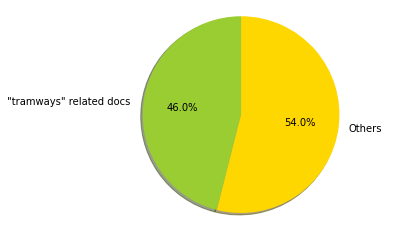

In [112]:
a = len(tramdoc)
b = len(clean_list)
x = (a / b)*100
print(str(int(x)) + "% of the documents in the corpus contains the word : 'tramways'")

labels = '"tramways" related docs ', 'Others'
sizes = [x,(100-x)]
colors = ['yellowgreen', 'gold']

plt.pie(sizes, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.show()

### Date d'apparition dans le corpus

In [ ]:
##Clean_Bxl_%y_Tome_XX_Part_X.txt"
tramdate = []
for d in tramdoc:
   datestring = ''.join(str(d))
   parsedate = dparser.parse(datestring,fuzzy=True)
   tramdate.append(parsedate)




##tramdate.sort(key=lambda date: datetime.strptime(date, "%y"))
print(tramdate)

### TF/IDF du mot "tramways" dans le corpus

In [113]:
# our corpus
data = clean_list

cv = CountVectorizer()

# convert text data into term-frequency matrix
data = cv.fit_transform(data)

tfidf_transformer = TfidfTransformer()

# convert term-frequency matrix into tf-idf
tfidf_matrix = tfidf_transformer.fit_transform(data)

# create dictionary to find a tfidf word each word
word2tfidf = dict(zip(cv.get_feature_names(), tfidf_transformer.idf_))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [111]:
dictionary = dict(word2tfidf)
search_word = "tramways"
for word, score in dictionary.items():
    if search_word in dictionary:
        print("TF/IDF score of: "+ "'"+ search_word + "'" + " is " + str(score))
        break

TF/IDF score of: 'tramways' is 8.200051688984663


### Analyse de sentiment sur les phrases contenant le mot "tramways"

In [ ]:
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

def get_sentiment(input_text):
    blob = tb(input_text)
    polarity, subjectivity = blob.sentiment
    polarity_perc = f"{100*abs(polarity):.0f}"
    subjectivity_perc = f"{100*subjectivity:.0f}"
    if polarity > 0:
        polarity_str = f"{polarity_perc}% positive"
    elif polarity < 0:
        polarity_str = f"{polarity_perc}% negative"
    else:
        polarity_str = "neutral"
    if subjectivity > 0:
        subjectivity_str = f"{subjectivity}% subjective"
    else:
        subjectivity_str = "perfectly objective"
    print(f"This text is {polarity_str} and {subjectivity_str}.")

In [ ]:
get_sentiment("Ce conseil municipal est vraiment super intéressant.")

### Recherche des entités nommées présentes dans les documents qui parlent du tramways

In [ ]:
nlp = spacy.load('fr_core_news_md')

In [ ]:
# Charger le texte
n=900000
text = open("../data/all.txt", encoding='utf-8').read()[:n]

In [ ]:
%%time
# Traiter le texte

doc = nlp(text)

In [ ]:
# Compter les entités
people = defaultdict(int)
for ent in doc.ents:
    if ent.label_ == "PER" and len(ent.text) > 3:
        people[ent.text] += 1

In [ ]:
# Trier et imprimer

sorted_people = sorted(people.items(), key=lambda kv: kv[1], reverse=True)

for person, freq in sorted_people[:50]:
    print(f"{person} apparait {freq} fois dans le corpus")

### Wordcloud 

In [ ]:
frequencies = Counter(after.split())
print(frequencies.most_common(10))

In [ ]:
cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies)
cloud.to_file(os.path.join(temp_path, f"{year}.png"))
Image(filename=os.path.join(temp_path, f"{year}.png"))